In [10]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [5]:
# load train and test data
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=False, transform=ToTensor())

In [11]:
# Load train and test data loader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
# Create a model
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [13]:
#Instantiate
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784, 
    hidden_units=10,
    output_shape=10
)
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [14]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
from tqdm.auto import tqdm

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    train_loss /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")     

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------

Train loss: 1.05878 | Test loss: 0.99506, Test acc: 64.13%

Epoch: 1
-------

Train loss: 0.91331 | Test loss: 0.90508, Test acc: 66.86%

Epoch: 2
-------

Train loss: 0.87982 | Test loss: 0.89476, Test acc: 66.46%



In [19]:
y_preds = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        y_logit = model_0(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred)
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

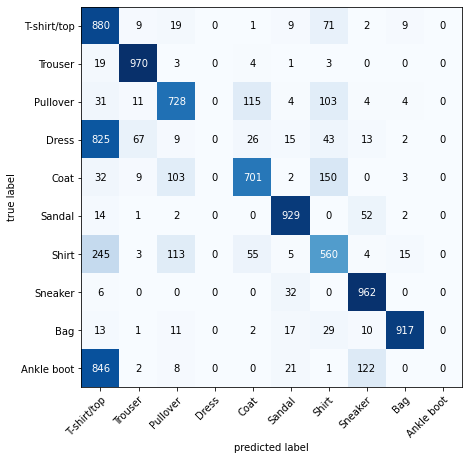

In [20]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=train_data.classes,
    figsize=(10, 7)
);